In [1]:
import logging
import json
import torch
from types import SimpleNamespace
from vilbert.vilbert import VILBertActionGrounding, BertConfig
from pytorch_transformers.tokenization_bert import BertTokenizer
from pytorch_transformers.optimization import AdamW, WarmupLinearSchedule
import torch.distributed as dist
from VLN_config import config as args
import random
import pandas as pd
from dataLoader import DataLoader

In [2]:
import sys
import os
import torch
import yaml

import numpy as np
import matplotlib.pyplot as plt
import PIL

from PIL import Image
import cv2
import argparse
import glob
import pdb

import torchvision.models as models
import torchvision.transforms as transforms

from faster_rcnn import feature_extractor_new as f_extractor
from faster_rcnn.feature_extractor_new import featureExtractor
#%matplotlib inline  

In [3]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)
print(args)

namespace(adam_epsilon=1e-08, baseline=False, bert_model='bert-base-uncased', best_features=5, clean_train_sets=True, config_file='config/bert_base_6layer_6conect.json', distributed=False, do_lower_case=True, dynamic_attention=False, from_pretrained='save_vilbert_action_grounding/vilberActionGrounding.bin', gradient_accumulation_steps=1, img_weight=1, in_memory=False, learning_rate=0.0001, local_rank=-1, max_temporal_memory_buffer=3, mean_layer=False, num_key_frames=6, num_train_epochs=10.0, num_workers=0, objective=1, predict_feature=False, save_name='', seed=42, split='mteval', start_epoch=0, task_specific_tokens=True, tasks='1', threshold_similarity=0.7, track_temporal_features=True, train_batch_size=4, use_tensorboard=True, visual_target=0, warmup_proportion=0.1, without_coattention=False)


In [4]:
tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)

07/24/2020 16:55:38 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/mikel/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [5]:
config = BertConfig.from_json_file(args.config_file)
bert_weight_name = json.load(
    open("config/" + args.bert_model + "_weight_name.json", "r")
)

tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)

config.track_temporal_features = args.track_temporal_features
config.mean_layer = args.mean_layer
config.max_temporal_memory_buffer = args.max_temporal_memory_buffer
config.visualization = True

#The path of the finetuned ActionGrounding weights
args.from_pretrained = "save_vilbert_action_grounding/vilberActionGrounding.bin"

print(args.from_pretrained)
model = VILBertActionGrounding.from_pretrained(
    args.from_pretrained, config=config, default_gpu=True
)

07/24/2020 16:55:41 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/mikel/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/24/2020 16:55:41 - INFO - vilbert.utils -   loading weights file save_vilbert_action_grounding/vilberActionGrounding.bin


save_vilbert_action_grounding/vilberActionGrounding.bin


In [6]:
# load data
frcnn_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
data_loader = DataLoader("json_data.json", frcnn_model, save_or_not = False)
path = 'DataLoader.pt'
data_loaded = data_loader.load_dataloader(path)

In [7]:
features_masked, pos_enc, spatial, image_mask, tokenized_text, masked_text, masked_lm_token, input_mask, segment_ids, co_attention_mask, infos, masked_img_labels  = data_loaded

In [8]:
#Forward the model with one input example
pred_t_train, pred_v_train, att_train = model(input_ids = masked_text[1].unsqueeze(0).cpu(),
                                image_feat = features_masked[1].unsqueeze(0).cpu(), # Linear(2048*config.max_temporal_memory_buffer, 2048)
                                image_loc = spatial[1].unsqueeze(0).cpu(),  #Linear(in_features=5, out_features=1024, bias=True)
                                image_pos_input = pos_enc[1].unsqueeze(0).cpu(),   #Linear(7, 2048)/(6, 2048)
                                token_type_ids = segment_ids[1].unsqueeze(0).cpu(), 
                                attention_mask = input_mask[1].unsqueeze(0).cpu(), 
                                image_attention_mask = image_mask[1].unsqueeze(0).cpu(),
                                output_all_attention_masks=True)

torch.Size([1, 37, 30522])
torch.Size([5, 37])


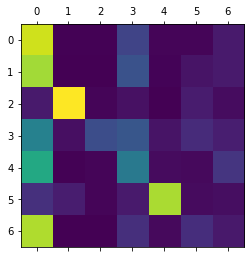

In [9]:
print(pred_t_train.shape)
print(att_train[0][0]["attn"][0,0,:5,:].shape) 
#Only 7 firts elements because the sentence is 5 + 2 special tokens
plt.matshow(att_train[0][0]["attn"][0,2,:7,:7].detach().numpy())